![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from keras import initializers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras import backend as K
from livelossplot import PlotLossesKeras

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [83]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","[Drama, Film-Noir, Thriller]",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",[Drama],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","[Action, Crime, Thriller]",6.6


In [111]:
# Cuáles son los géneros?
dataTraining['genres']
pd.Series([genre for genres in dataTraining['genres'] for genre in genres]).unique()


array(['Short', 'Drama', 'Comedy', 'Crime', 'Horror', 'Film-Noir',
       'Thriller', 'Action', 'Western', 'Family', 'Fantasy', 'Romance',
       'Sport', 'Adventure', 'Mystery', 'Sci-Fi', 'Documentary',
       'History', 'Music', 'Biography', 'War', 'Musical', 'Animation',
       'News'], dtype=object)

In [5]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [60]:
# Definición de variable de interés (y)
#dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

y_genres.tolist()

[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0,

In [124]:
import nltk
from nltk.stem import WordNetLemmatizer

# Definición de variables predictoras (X)

# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(dataTraining['plot'], y_genres, test_size=0.33, random_state=42)

# Lematización
lemmatizer = WordNetLemmatizer()

def lemmatize_verbs(text):
    tagged_text = nltk.pos_tag(text.split()) # Part of speech tagging
    lemmatized_tokens = [lemmatizer.lemmatize(word, 'v') if tag.startswith('V') else word for word, tag in tagged_text] # Lematización solo de verbos
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

X_train_lemmatized = X_train.apply(lemmatize_verbs)
X_test_lemmatized = X_test.apply(lemmatize_verbs)


In [125]:
vectorizer = CountVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train_lemmatized).toarray()
X_test_vectorized = vectorizer.transform(X_test_lemmatized).toarray()

In [130]:
y_train_genres.shape

(5289, 24)

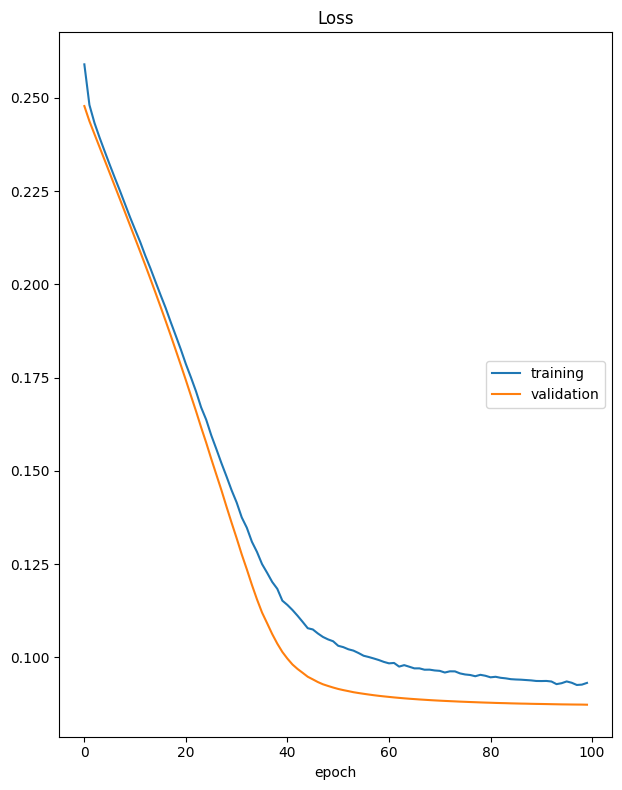

Loss
	training         	 (min:    0.093, max:    0.259, cur:    0.093)
	validation       	 (min:    0.087, max:    0.248, cur:    0.087)
166/166 [==============================] - 1s 7ms/step - loss: 0.0931 - val_loss: 0.0873


In [141]:
K.clear_session()

dims = X_train_vectorized.shape[1]
output_var = y_train_genres.shape[1]

model_nn_multi2 = Sequential()
model_nn_multi2.add(Dense(96, activation='relu', input_shape=(dims,)))
model_nn_multi2.add(Dropout(0.5))
model_nn_multi2.add(Dense(72, activation='relu'))
model_nn_multi2.add(Dropout(0.5))
model_nn_multi2.add(Dense(48, activation='relu'))
model_nn_multi2.add(Dropout(0.5))
model_nn_multi2.add(Dense(output_var, activation='sigmoid'))

model_nn_multi2.compile(loss='mean_squared_error', optimizer='sgd')

history = model_nn_multi2.fit(X_train_vectorized, y_train_genres, 
                    validation_data=(X_test_vectorized, y_test_genres), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[PlotLossesKeras()],
                    verbose=1)


In [142]:
y_pred = model_nn_multi2.predict(X_test_vectorized)
mse_nn_multi2 = mean_squared_error(y_test_genres, y_pred)   
mae_nn_multi2 = mean_absolute_error(y_test_genres, y_pred)   
print('Error absoluto medio (MAE):', mae_nn_multi2)
print('Error cuadrático medio (MSE):', mse_nn_multi2)

82/82 [==============================] - 0s 2ms/step
Error absoluto medio (MAE): 0.17777945130096937
Error cuadrático medio (MSE): 0.08727750650590844


In [116]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test_vectorized)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7942414053922976

In [28]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [29]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.143030,0.101960,0.024454,0.029938,0.354552,0.138830,0.030787,0.490140,0.073159,0.101339,...,0.025069,0.063208,0.000000,0.362818,0.056648,0.008970,0.017522,0.202605,0.033989,0.018117
4,0.122624,0.085786,0.024213,0.084795,0.370949,0.216657,0.080359,0.515684,0.062976,0.067019,...,0.024734,0.060935,0.000477,0.149703,0.058190,0.014248,0.020099,0.204794,0.030438,0.018506
5,0.151364,0.110284,0.013762,0.075334,0.304837,0.448736,0.021010,0.611544,0.081741,0.169121,...,0.044538,0.261372,0.000000,0.335987,0.128505,0.001016,0.048658,0.423242,0.052693,0.025351
6,0.154448,0.125772,0.020991,0.064124,0.340779,0.140892,0.009133,0.632038,0.068287,0.063631,...,0.131074,0.088418,0.000000,0.197224,0.132208,0.001432,0.039743,0.269385,0.077607,0.017862
7,0.175143,0.210069,0.035476,0.032505,0.313850,0.243150,0.021793,0.427885,0.079781,0.143879,...,0.023859,0.090359,0.000048,0.205117,0.241663,0.002634,0.018403,0.259465,0.021569,0.017585
